In [ ]:
import ee
import folium
import geopandas as gpd
import json
import geemap
import ee
import xarray as xr

# === Initialize Earth Engine ===
ee.Authenticate()
ee.Initialize()

# === Load AOI from GeoJSON ===
geojson_path = r"C:\Ocean\Work\Projects\2025\Mangroves\Data\0_Workflow\1_Tiles\Indonesia\TIL_N00E117_S01E117_2025.geojson"  # update this path
gdf = gpd.read_file(geojson_path)
geojson_str = gdf.to_json()
geojson_dict = json.loads(geojson_str)
aoi_geom = ee.Geometry(geojson_dict['features'][0]['geometry'])

# === Load and clip ESA WorldCover ===
esa_image = ee.ImageCollection('ESA/WorldCover/v200') \
    .first() \
    .clip(aoi_geom)

# === Visualization parameters (ESA land cover classes) ===
esa_vis = {
    'min': 10,
    'max': 100,
    'palette': [
        '006400', 'ffbb22', 'ffff4c', 'f096ff', 'fa0000',
        'b4b4b4', 'f0f0f0', '0064c8', '0096a0', '00cf75',
        'fae6a0', 'b4a76c', '00ff00', 'c8c8c8', '8f8f8f'
    ]
}

# === Create folium Map ===
center = gdf.geometry.centroid.iloc[0].y, gdf.geometry.centroid.iloc[0].x
m = folium.Map(location=center, zoom_start=10)

# Add ESA WorldCover image layer
map_id_dict = ee.Image(esa_image).getMapId(esa_vis)
folium.TileLayer(
    tiles=map_id_dict['tile_fetcher'].url_format,
    attr='ESA WorldCover',
    name='ESA WorldCover 2020',
    overlay=True,
    control=True
).add_to(m)

# Add AOI as GeoJSON overlay
folium.GeoJson(geojson_dict, name="AOI").add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Display map
m


In [ ]:
# === Export region: use AOI bounds ===
export_region = aoi_geom.bounds()

# === Export task to Google Drive ===
task = ee.batch.Export.image.toDrive(
    image=esa_image,
    description='ESA_WorldCover_Clipped',
    folder='GEE_Exports',  # Google Drive folder (create it manually if it doesn't exist)
    fileNamePrefix='esa_worldcover_clipped',
    region=export_region.getInfo()['coordinates'],
    scale=15,  # ESA WorldCover is 10 m resolution
    maxPixels=1e13
)

# === Start the export task ===
task.start()
print("Export started. Check https://code.earthengine.google.com/tasks to monitor progress.")

# Converting to xarray (This task task too long)
# # Load image and define area
# image = ee.ImageCollection("ESA/WorldCover/v200").first()
# # region = ee.Geometry.Point([117, 0]).buffer(1000).bounds()

# # Extract as NumPy array
# array = geemap.ee_to_numpy(image, region=aoi_geom, scale=10)

# # Convert to DataArray
# da = xr.DataArray(array.squeeze(), dims=["y", "x"])


In [ ]:
import json
import geopandas as gpd
from shapely.geometry import box
import pystac_client
import planetary_computer
from IPython.display import Image
import odc.stac

# === Load GeoJSON and extract bounding box ===
geojson_path = geojson_path = r"C:\Ocean\Work\Projects\2025\Mangroves\Data\0_Workflow\1_Tiles\Indonesia\TIL_N00E117_S01E117_2025.geojson"  # update this path
gdf = gpd.read_file(geojson_path)

# === Reproject to a projected CRS (e.g., UTM or EPSG:3857) ===
# Pick a suitable projected CRS for your region (below is global Web Mercator)
gdf_proj = gdf.to_crs(epsg=3857)

# === Apply negative buffer of 10,000 meters ===
gdf_buffered = gdf_proj.buffer(-10000)

# Wrap back into GeoDataFrame
gdf_buffered = gpd.GeoDataFrame(geometry=gdf_buffered, crs=gdf_proj.crs)

# === Reproject back to WGS84 for bounding box ===
gdf_wgs84 = gdf_buffered.to_crs(epsg=4326)

# === Get bounding box for STAC search ===
minx, miny, maxx, maxy = gdf_wgs84.total_bounds
bbox_of_interest = [minx, miny, maxx, maxy]

# Print or use in your search
print("Buffered BBOX:", bbox_of_interest)

# gdf = gpd.read_file(geojson_path)

# # Optional: Reproject to WGS84 (EPSG:4326) if needed
# if gdf.crs != "EPSG:4326":
#     gdf = gdf.to_crs("EPSG:4326")

# # Get bounds: [minx, miny, maxx, maxy]
# minx, miny, maxx, maxy = gdf.total_bounds
# bbox_of_interest = [minx, miny, maxx, maxy]

# === STAC Query with Planetary Computer ===
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

search = catalog.search(
    collections=["esa-worldcover"],
    bbox=bbox_of_interest,
)

items = list(search.get_items())
items_filtered = [item for item in items if item.properties.get("esa_worldcover:product_version") == "2.0.0"]

Buffered BBOX: [np.float64(117.08983152841195), np.float64(-0.9101809613041663), np.float64(117.91016847158703), np.float64(-0.08983149160841292)]


c:\Users\fuentesm\AppData\Local\miniforge3\envs\coastal\Lib\site-packages\pystac_client\item_search.py:881: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


[<Item id=ESA_WorldCover_10m_2021_v200_S03E117>]

In [ ]:
Image(url=items_filtered[0].assets["rendered_preview"].href)

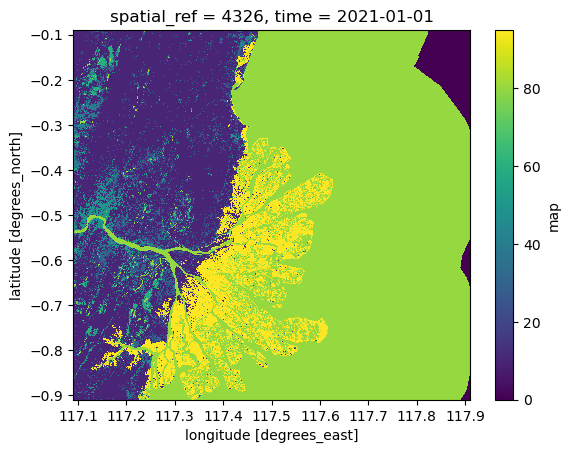

In [ ]:
ds = odc.stac.load(items_filtered, crs="EPSG:4326", resolution=0.00027, bbox=bbox_of_interest)
map_data = ds["map"].isel(time=0).load()
map_data.plot()